In [1]:
# 기본 라이브러리 임포트
import pandas as pd             
import numpy as np             
import matplotlib.pyplot as plt 
import seaborn as sns           
import gc                       # 가비지 컬렉션(메모리 해제)
import re                       # 정규 표현식 처리
from collections import defaultdict  # 기본값이 있는 딕셔너리 생성

# 경고 메시지 억제
import warnings
warnings.filterwarnings('ignore')   

# 그래프 스타일 설정
sns.set()                           # seaborn 기본 스타일 적용

# matplotlib 그래프 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # 한글 폰트 설정
# plt.rcParams['font.family'] = 'AppleGothic'  
plt.rcParams['figure.figsize'] = (12, 6)       # 그림 크기 설정 (가로, 세로)
plt.rcParams['font.size'] = 14                 # 폰트 크기 설정
plt.rcParams['axes.unicode_minus'] = False     # 마이너스 기호 깨짐 방지

# 결측치 시각화 라이브러리 임포트
import missingno                          # 결측치 분포를 시각화하는 유틸리티

# 범주형 변수 레이블 인코딩을 위한 도구 임포트
from sklearn.preprocessing import LabelEncoder

# 중복 조합 생성에 사용할 product 함수 임포트
from itertools import product

# 회귀 및 통계 분석을 위한 statsmodels 임포트
import statsmodels.api as sm

# 다중공선성 진단용 VIF 계산 함수 임포트
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
# 데이터 가져오기
marketing_df   = pd.read_csv('마케팅정보_최종.csv')
performance_df = pd.read_csv('성과정보12월_feat_select.csv')
credit_df = pd.read_csv('신용정보12월_feat_select.csv')
channel_df = pd.read_csv('채널정보_최종.csv')
member_df = pd.read_csv('회원정보12월_feat_select.csv')
balance_df = pd.read_csv('charge_balance_201812.csv')
approval_df = pd.read_csv('승인매출정보_최종.csv')

# 보조 데이터프레임에서 Segment 제거
dfs = [performance_df, credit_df, channel_df, member_df, balance_df, approval_df]
for df in dfs:
    if 'Segment' in df.columns:
        df.drop(columns=['Segment'], inplace=True)

# 순차 병합
merged_df = marketing_df.copy()
for df in dfs:
    merged_df = (
        merged_df
        .merge(df, on='ID', how='left')
        .drop_duplicates(subset='ID')
    )

# 기준년월 제거
if '기준년월' in merged_df.columns:
    merged_df.drop(columns=['기준년월'], inplace=True)

In [3]:
# 원-핫 인코딩 카드론동의여부
onehot = pd.get_dummies(merged_df['카드론동의여부'], prefix='카드론동의여부')
merged_df = pd.concat([merged_df, onehot], axis=1).drop(columns=['카드론동의여부'])

In [4]:
# PCA에 사용할 컬럼 리스트 지정
pca_cols = [
    '잔액_신판ca최대한도소진율_r3m', '증감율_이용금액_신판_전월', '잔액_신판ca평균한도소진율_r6m',
    '변동률_RVCA평잔', '혜택수혜율_R3M', '카드이용한도금액_B1M', '카드이용한도금액',
    '일시불ONLY전환가능여부', '상향가능한도금액', 'rv최초시작후경과일', 'RV현금서비스이자율_할인전',
    '방문후경과월_PC_R6M', '인입일수_ARS_R6M', '홈페이지_금융건수_R6M', '방문월수_PC_R6M',
    '인입일수_ARS_B0M', '방문월수_앱_R6M', '입회일자_신용', '이용금액_R3M_신용체크',
    '이용가능카드수_신용', '마일_적립포인트_R3M', '할인금액_R3M', '청구금액_R3M',
    '포인트_이용포인트_R3M', '할인금액_청구서_R3M', '혜택수혜금액', '상환개월수_결제일_R6M',
    '포인트_마일리지_환산_B0M', '포인트_적립포인트_R3M', '최대이용금액_체크_R12M',
    '잔액_신판ca최대한도소진율_r6m', '_1순위카드이용금액', '캠페인접촉건수_R12M_num',
    '정상청구원금_B2M', '회원여부_이용가능_카드론', '컨택건수_이용유도_EM_R6M'
]


# PCA용 데이터 준비
X_pca = merged_df[pca_cols].fillna(0)

# 스케일링 평균 0 분산 1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)

# 전체 주성분 모델 생성 및 학습
pca = PCA()
pca.fit(X_scaled)

# 설명 분산 비율과 누적 분산
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

엘보우 포인트(주성분 개수): 34


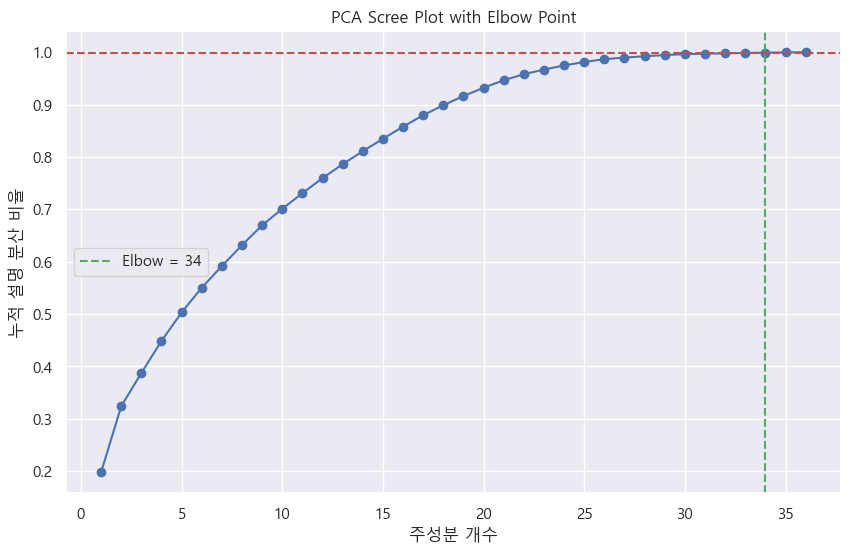

In [5]:
# 계산 일차 미분 (각 주성분 추가 시 누적분산 변화량)
first_diff = np.diff(cumulative_var)

# 계산 이차 미분 (변화량의 변화량)
second_diff = np.diff(cumulative_var, n=2)

# 선정 엘보우 포인트 (이차 미분이 최대가 되는 인덱스 +2)
elbow_index = np.argmax(second_diff) + 2
print('엘보우 포인트(주성분 개수):', elbow_index)

# 그리기 Scree Plot (누적 설명 분산 + 엘보우 표시)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_var) + 1), cumulative_var, marker='o')
plt.axvline(x=elbow_index, color='g', linestyle='--', label=f'Elbow = {elbow_index}')
plt.axhline(y=cumulative_var[elbow_index-1], color='r', linestyle='--')
plt.xlabel('주성분 개수')
plt.ylabel('누적 설명 분산 비율')
plt.title('PCA Scree Plot with Elbow Point')
plt.grid(True)
plt.legend()
plt.show()

# 설정 최종 주성분 개수로 PCA 재학습
pca_elbow = PCA(n_components=elbow_index)
X_elbow = pca_elbow.fit_transform(X_scaled)

# 주성분 DataFrame 생성
elbow_df = pd.DataFrame(X_elbow, columns=[f'PC{i+1}' for i in range(elbow_index)])
elbow_df['ID'] = merged_df['ID']

In [6]:
# PCA 결과 저장
elbow_df.to_csv('PCA.csv', index=False, encoding='utf-8-sig')

In [7]:
# ID 컬럼 추가
elbow_df['ID'] = merged_df['ID']

# PCA 결과에 ID 추가 확인
print(elbow_df[['ID']].head())

# PCA 결과를 CSV로 저장
elbow_df.to_csv('PCA.csv', index=False, encoding='utf-8-sig')

             ID
0  TRAIN_000000
1  TRAIN_000001
2  TRAIN_000002
3  TRAIN_000003
4  TRAIN_000004


In [8]:
# 최종 학습/테스트 데이터
train_df = pd.read_csv('final_train.csv')
test_df  = pd.read_csv('final_test.csv')


# ID가 포함된 PCA 결과
pca_df = pd.read_csv('PCA.csv')

In [9]:
# ID가 TRAIN으로 시작하면 학습용, TEST로 시작하면 테스트용
train_pca = elbow_df[elbow_df['ID'].str.startswith('TRAIN')].copy()
test_pca  = elbow_df[elbow_df['ID'].str.startswith('TEST')].copy()

# 학습 데이터에 PCA 피처 추가
train_df = train_df.merge(train_pca, on='ID', how='left')

# 테스트 데이터에 PCA 피처 추가
test_df  = test_df.merge(test_pca, on='ID', how='left')

# 병합 결과 일부 출력
print(train_df.head())
print(test_df.head())

             ID Segment  컨택건수_이용유도_청구서_B0M  컨택건수_이용유도_TM_R6M  \
0  TRAIN_000000       D                  0                 0   
1  TRAIN_000001       E                  0                 0   
2  TRAIN_000002       C                  0                 0   
3  TRAIN_000003       D                  0                 0   
4  TRAIN_000004       E                  1                 3   

   컨택건수_이용유도_EM_B0M  컨택건수_이용유도_인터넷_R6M  컨택건수_이용유도_LMS_R6M  컨택건수_이용유도_LMS_B0M  \
0                13                  0                 12                  2   
1                 0                  3                  4                  2   
2                 1                  0                  0                  0   
3                 2                  0                 12                  2   
4                 0                  0                 14                  2   

   캠페인접촉일수_R12M_num  컨택건수_이용유도_청구서_R6M  ...      PC25      PC26      PC27  \
0                 1                  0  ...  0.511397 -0.